# MRS cross-dichroic internal calibration source measurements
We load all the MRS detector images from the nominal and cross-dichroic observations of the MIRI internal calibration source. By taking a ratio of cross-to-nominal dichroic configuration measurements, these can be compared on the basis of the dichroics involved.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# MRS spectral bands (including cross-dichroic configurations)
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C", 
         "2AxB","2AxC","2BxA","2BxC","2CxA","2CxB",
         "3AxB","3AxC","3BxA","3BxC","3CxA","3CxB",
         "4AxB","4AxC","4BxA","4BxC","4CxA","4CxB"]

In [4]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
dichroicDir   = workDir+'MRSWaveCal/MrsFilterTransmissions/'
lvl2path  = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}

for band in bands:
    if len(band) == 4:
        # cross-dichroic configuration
        continue
    # print "Band {}".format(band)
    d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr10pc'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band,d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

In [5]:
# Populate dictionaries with maps of S_pix [DN/sec] and dS_pix (the error)
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.
# We also populate the Bad pixel map (0 = ok, 1 = do not use)

S_pixMap = {}
dS_pixMap = {}
BadPixelMap = {}
for band in bands:
    if len(band) == 4:
        # cross-dichroic configuration
        validMap[band] = validMap[band[:2]]
    S_pixMap[band] = np.full( validMap[band].shape, np.nan )
    dS_pixMap[band] = np.full( validMap[band].shape, np.nan )
    BadPixelMap[band] = np.full( validMap[band].shape, 0 )
    hdulist = fits.open(mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM',output='filename'))
    slope = hdulist[0].data[0,:,:]
    dslope = hdulist[0].data[1,:,:]
    mask = hdulist[0].data[2,:,:]
    sel = (validMap[band]==1) & (mask==0)
    S_pixMap[band][sel] = slope[sel]
    dS_pixMap[band][sel] = np.sqrt(dslope[sel]**2)
    BadPixelMap[band][(validMap[band]==1) & (mask>0)] = 1
    
# save signal output
funcs.save_obj(S_pixMap,'NominalAndCrossDichroicIntCalSourceSignal')
funcs.save_obj(dS_pixMap,'NominalAndCrossDichroicIntCalSourceSignalError')

We plot the detector images from MIRI internal calibration source observations in each MRS nominal and cross-dichroic configuration.

<IPython.core.display.Javascript object>


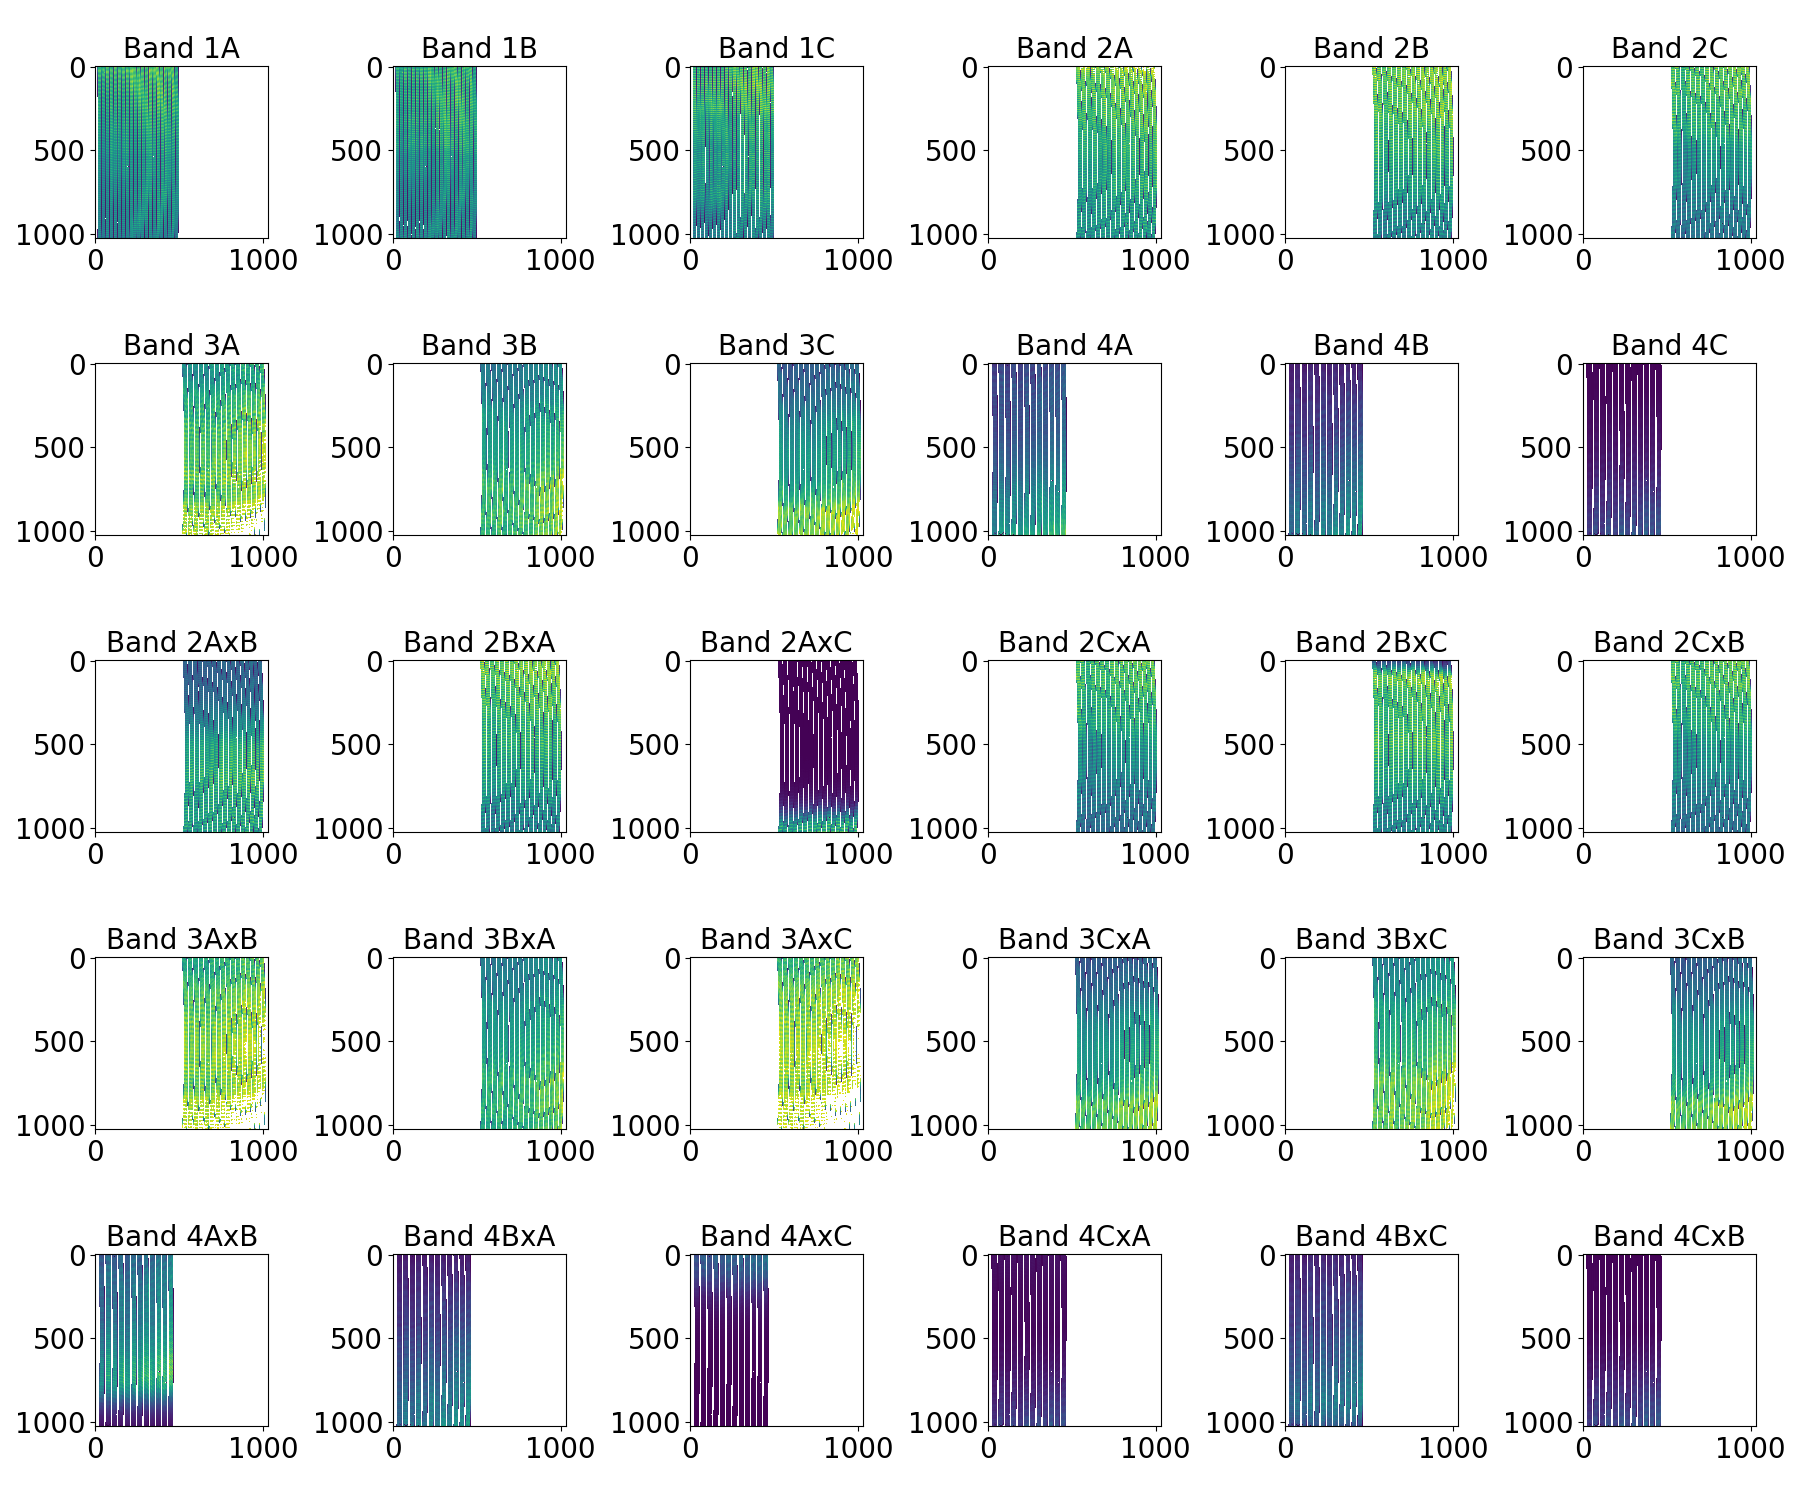

In [6]:
fig,axs = plt.subplots(5,6,figsize=(18,15))
axs[0,0].imshow(S_pixMap['1A'])
axs[0,0].set_title('Band 1A')
axs[0,1].imshow(S_pixMap['1B'])
axs[0,1].set_title('Band 1B')
axs[0,2].imshow(S_pixMap['1C'])
axs[0,2].set_title('Band 1C')
axs[0,3].imshow(S_pixMap['2A'])
axs[0,3].set_title('Band 2A')
axs[0,4].imshow(S_pixMap['2B'])
axs[0,4].set_title('Band 2B')
axs[0,5].imshow(S_pixMap['2C'])
axs[0,5].set_title('Band 2C')
axs[1,0].imshow(S_pixMap['3A'])
axs[1,0].set_title('Band 3A')
axs[1,1].imshow(S_pixMap['3B'])
axs[1,1].set_title('Band 3B')
axs[1,2].imshow(S_pixMap['3C'])
axs[1,2].set_title('Band 3C')
axs[1,3].imshow(S_pixMap['4A'])
axs[1,3].set_title('Band 4A')
axs[1,4].imshow(S_pixMap['4B'])
axs[1,4].set_title('Band 4B')
axs[1,5].imshow(S_pixMap['4C'])
axs[1,5].set_title('Band 4C')
axs[2,0].imshow(S_pixMap['2AxB'])
axs[2,0].set_title('Band 2AxB')
axs[2,1].imshow(S_pixMap['2BxA'])
axs[2,1].set_title('Band 2BxA')
axs[2,2].imshow(S_pixMap['2AxC'])
axs[2,2].set_title('Band 2AxC')
axs[2,3].imshow(S_pixMap['2CxA'])
axs[2,3].set_title('Band 2CxA')
axs[2,4].imshow(S_pixMap['2BxC'])
axs[2,4].set_title('Band 2BxC')
axs[2,5].imshow(S_pixMap['2CxB'])
axs[2,5].set_title('Band 2CxB')
axs[3,0].imshow(S_pixMap['3AxB'])
axs[3,0].set_title('Band 3AxB')
axs[3,1].imshow(S_pixMap['3BxA'])
axs[3,1].set_title('Band 3BxA')
axs[3,2].imshow(S_pixMap['3AxC'])
axs[3,2].set_title('Band 3AxC')
axs[3,3].imshow(S_pixMap['3CxA'])
axs[3,3].set_title('Band 3CxA')
axs[3,4].imshow(S_pixMap['3BxC'])
axs[3,4].set_title('Band 3BxC')
axs[3,5].imshow(S_pixMap['3CxB'])
axs[3,5].set_title('Band 3CxB')
axs[4,0].imshow(S_pixMap['4AxB'])
axs[4,0].set_title('Band 4AxB')
axs[4,1].imshow(S_pixMap['4BxA'])
axs[4,1].set_title('Band 4BxA')
axs[4,2].imshow(S_pixMap['4AxC'])
axs[4,2].set_title('Band 4AxC')
axs[4,3].imshow(S_pixMap['4CxA'])
axs[4,3].set_title('Band 4CxA')
axs[4,4].imshow(S_pixMap['4BxC'])
axs[4,4].set_title('Band 4BxC')
axs[4,5].imshow(S_pixMap['4CxB'])
axs[4,5].set_title('Band 4CxB')
plt.tight_layout()

### Remarks:
* Band 2AxC has a very low response.
* Bands 2A, 3A, 3AxB and 3AxC have a large amount of "bad" pixels.

By taking the ratio of nominal and cross-configuration MRS signals, the involved dichroic transmissions can be extracted. The latter is the compared to the lab data of the MRS dichroic transmissions.
### > Channel 1-3

In [7]:
# Path to dichroic transmission data
MrsFilterTransmDir   = workDir+"MRSWaveCal/MrsFilterTransmissions/"
# Read the measured transmission curves from the csv files
# zeroth colum is wavelength [micrometer]
# first column is room temperature transmission
# second column is 7K transmission
col = 2
filterWave= np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1a.csv", delimiter=";")[:,0]
D1A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1a.csv", delimiter=";")[:,col]/100.
D1B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1b.csv", delimiter=";")[:,col]/100.
D1C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1c.csv", delimiter=";")[:,col]/100.
D2A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2a.csv", delimiter=";")[:,col]/100.
D2B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2b.csv", delimiter=";")[:,col]/100.
D2C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2c.csv", delimiter=";")[:,col]/100.
D3A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3a.csv", delimiter=";")[:,col]/100.
D3B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3b.csv", delimiter=";")[:,col]/100.
D3C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3c.csv", delimiter=";")[:,col]/100.


<IPython.core.display.Javascript object>


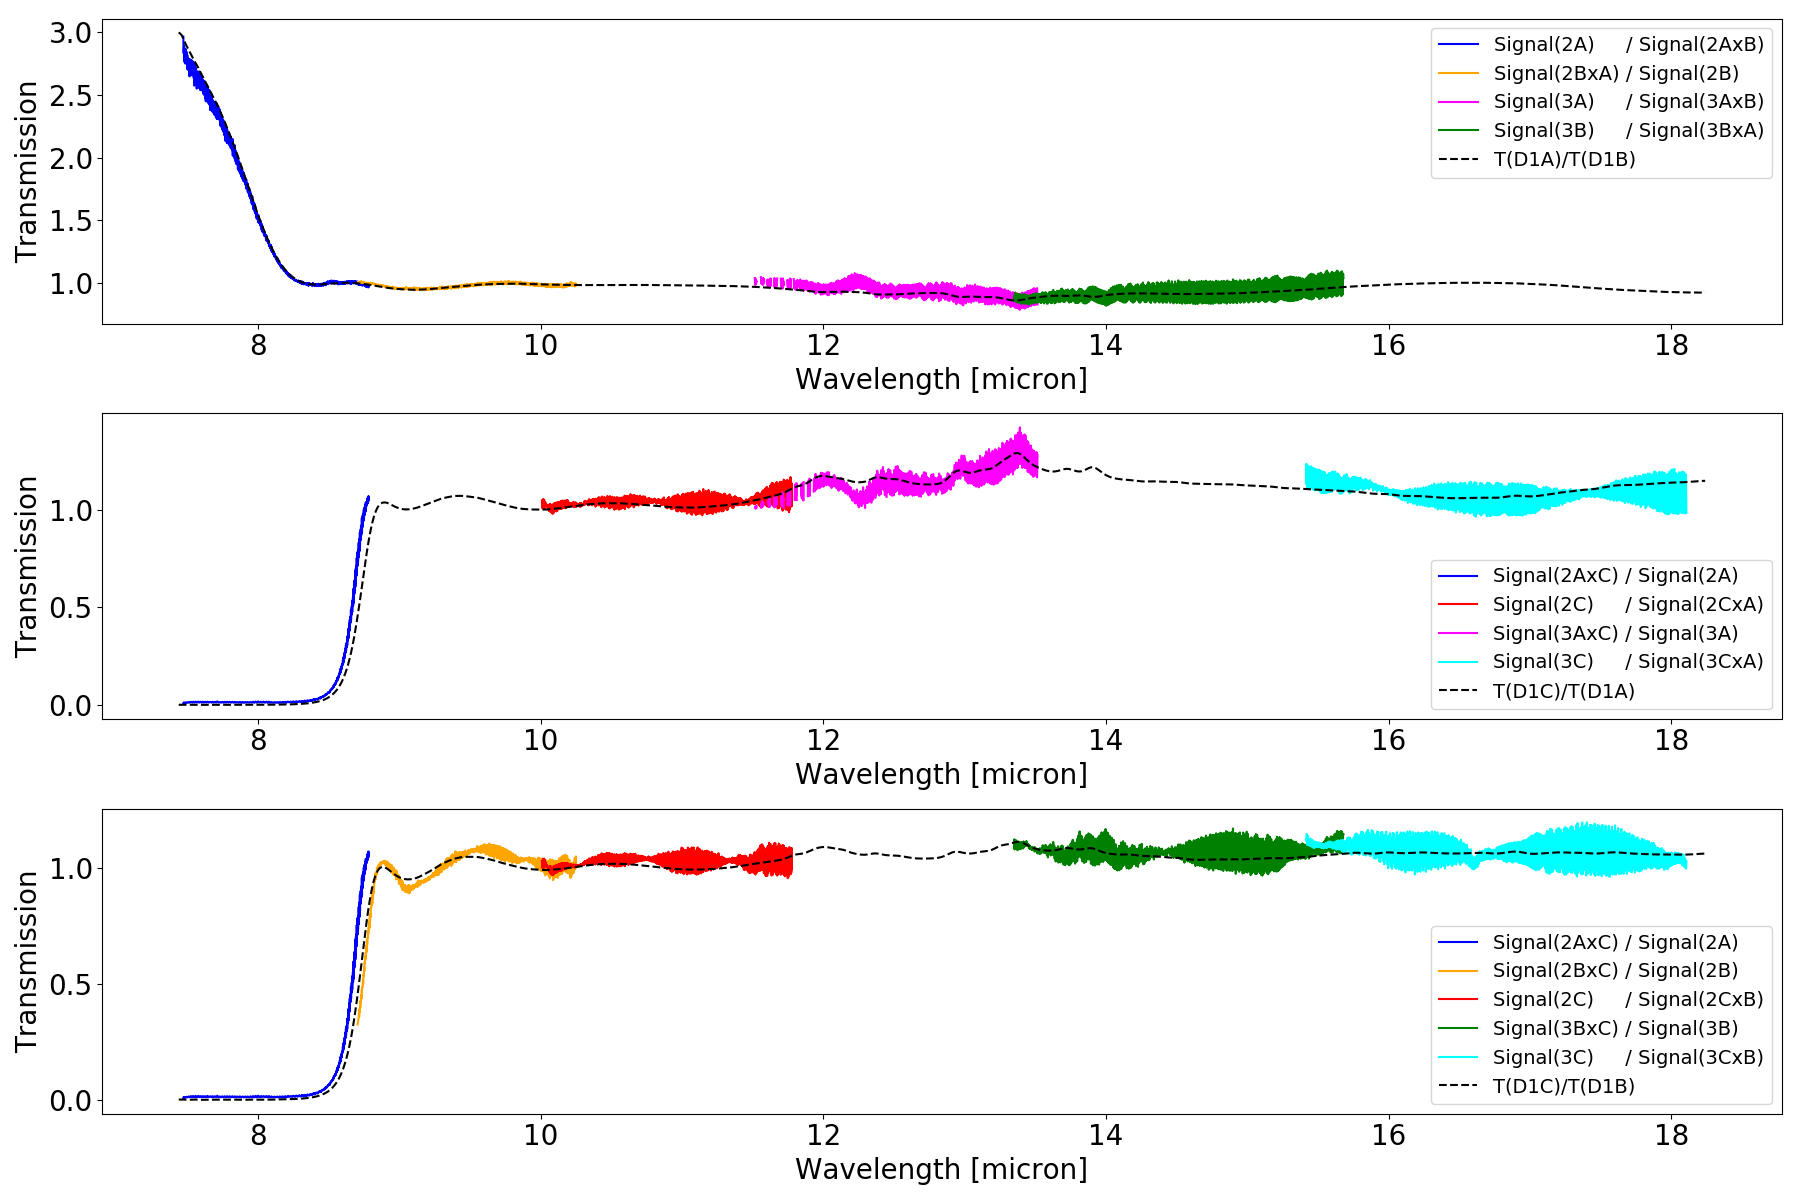

In [8]:
import mrs_aux as maux
sel = (filterWave>=maux.MRS_bands['2A'][0]) & (filterWave<=maux.MRS_bands['3C'][1])
fig,axs = plt.subplots(3,1,figsize=(18,12))
axs[0].plot(lambdaMap['2A'][:,537],(S_pixMap["2A"]/S_pixMap["2AxB"])[:,537],'b',label='Signal(2A)     / Signal(2AxB)')
axs[0].plot(lambdaMap['2B'][:,537],(S_pixMap["2BxA"]/S_pixMap["2B"])[:,537],'orange',label='Signal(2BxA) / Signal(2B)')
axs[0].plot(lambdaMap['3A'][:,537],(S_pixMap["3A"]/S_pixMap["3AxB"])[:,537],'magenta',label='Signal(3A)     / Signal(3AxB)')
axs[0].plot(lambdaMap['3B'][:,537],(S_pixMap["3BxA"]/S_pixMap["3B"])[:,537],'g',label='Signal(3B)     / Signal(3BxA)')
axs[0].plot(filterWave[sel],(D1A/D1B)[sel],'k',linestyle='dashed',label='T(D1A)/T(D1B)')

axs[1].plot(lambdaMap['2A'][:,537],(S_pixMap["2AxC"]/S_pixMap["2A"])[:,537],'b',label='Signal(2AxC) / Signal(2A)')
axs[1].plot(lambdaMap['2C'][:,537],(S_pixMap["2C"]/S_pixMap["2CxA"])[:,537],'r',label='Signal(2C)     / Signal(2CxA)')
axs[1].plot(lambdaMap['3A'][:,537],(S_pixMap["3AxC"]/S_pixMap["3A"])[:,537],'magenta',label='Signal(3AxC) / Signal(3A)')
axs[1].plot(lambdaMap['3C'][:,537],(S_pixMap["3C"]/S_pixMap["3CxA"])[:,537],'cyan',label='Signal(3C)     / Signal(3CxA)')
axs[1].plot(filterWave[sel],(D1C/D1A)[sel],'k',linestyle='dashed',label='T(D1C)/T(D1A)')

axs[2].plot(lambdaMap['2A'][:,537],(S_pixMap["2AxC"]/S_pixMap["2A"])[:,537],'b',label='Signal(2AxC) / Signal(2A)')
axs[2].plot(lambdaMap['2B'][:,537],(S_pixMap["2BxC"]/S_pixMap["2B"])[:,537],'orange',label='Signal(2BxC) / Signal(2B)')
axs[2].plot(lambdaMap['2C'][:,537],(S_pixMap["2C"]/S_pixMap["2CxB"])[:,537],'r',label='Signal(2C)     / Signal(2CxB)')
axs[2].plot(lambdaMap['3B'][:,537],(S_pixMap["3BxC"]/S_pixMap["3B"])[:,537],'g',label='Signal(3BxC) / Signal(3B)')
axs[2].plot(lambdaMap['3C'][:,537],(S_pixMap["3C"]/S_pixMap["3CxB"])[:,537],'cyan',label='Signal(3C)     / Signal(3CxB)')
axs[2].plot(filterWave[sel],(D1C/D1B)[sel],'k',linestyle='dashed',label='T(D1C)/T(D1B)')

for plot in range(3):
    axs[plot].legend()
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Transmission')
plt.tight_layout()

### Remarks:
* There is good agreement between the ratio of cross-dichroic response and nominal dichroic response, compared against the ratio of the "lab data" filter transmissions.
* To avoid introducing noise into the MRS (PHOTOM) cross-dichroic responses, one could envisage using the lab data of the dichroic transmissions. As such the cross-dichroic response is computed as the nominal MRS response (derived from the external extended source spectra), mulitplied by a corresponding ratio of lab data transmissions. 

### > Channel 4

<IPython.core.display.Javascript object>


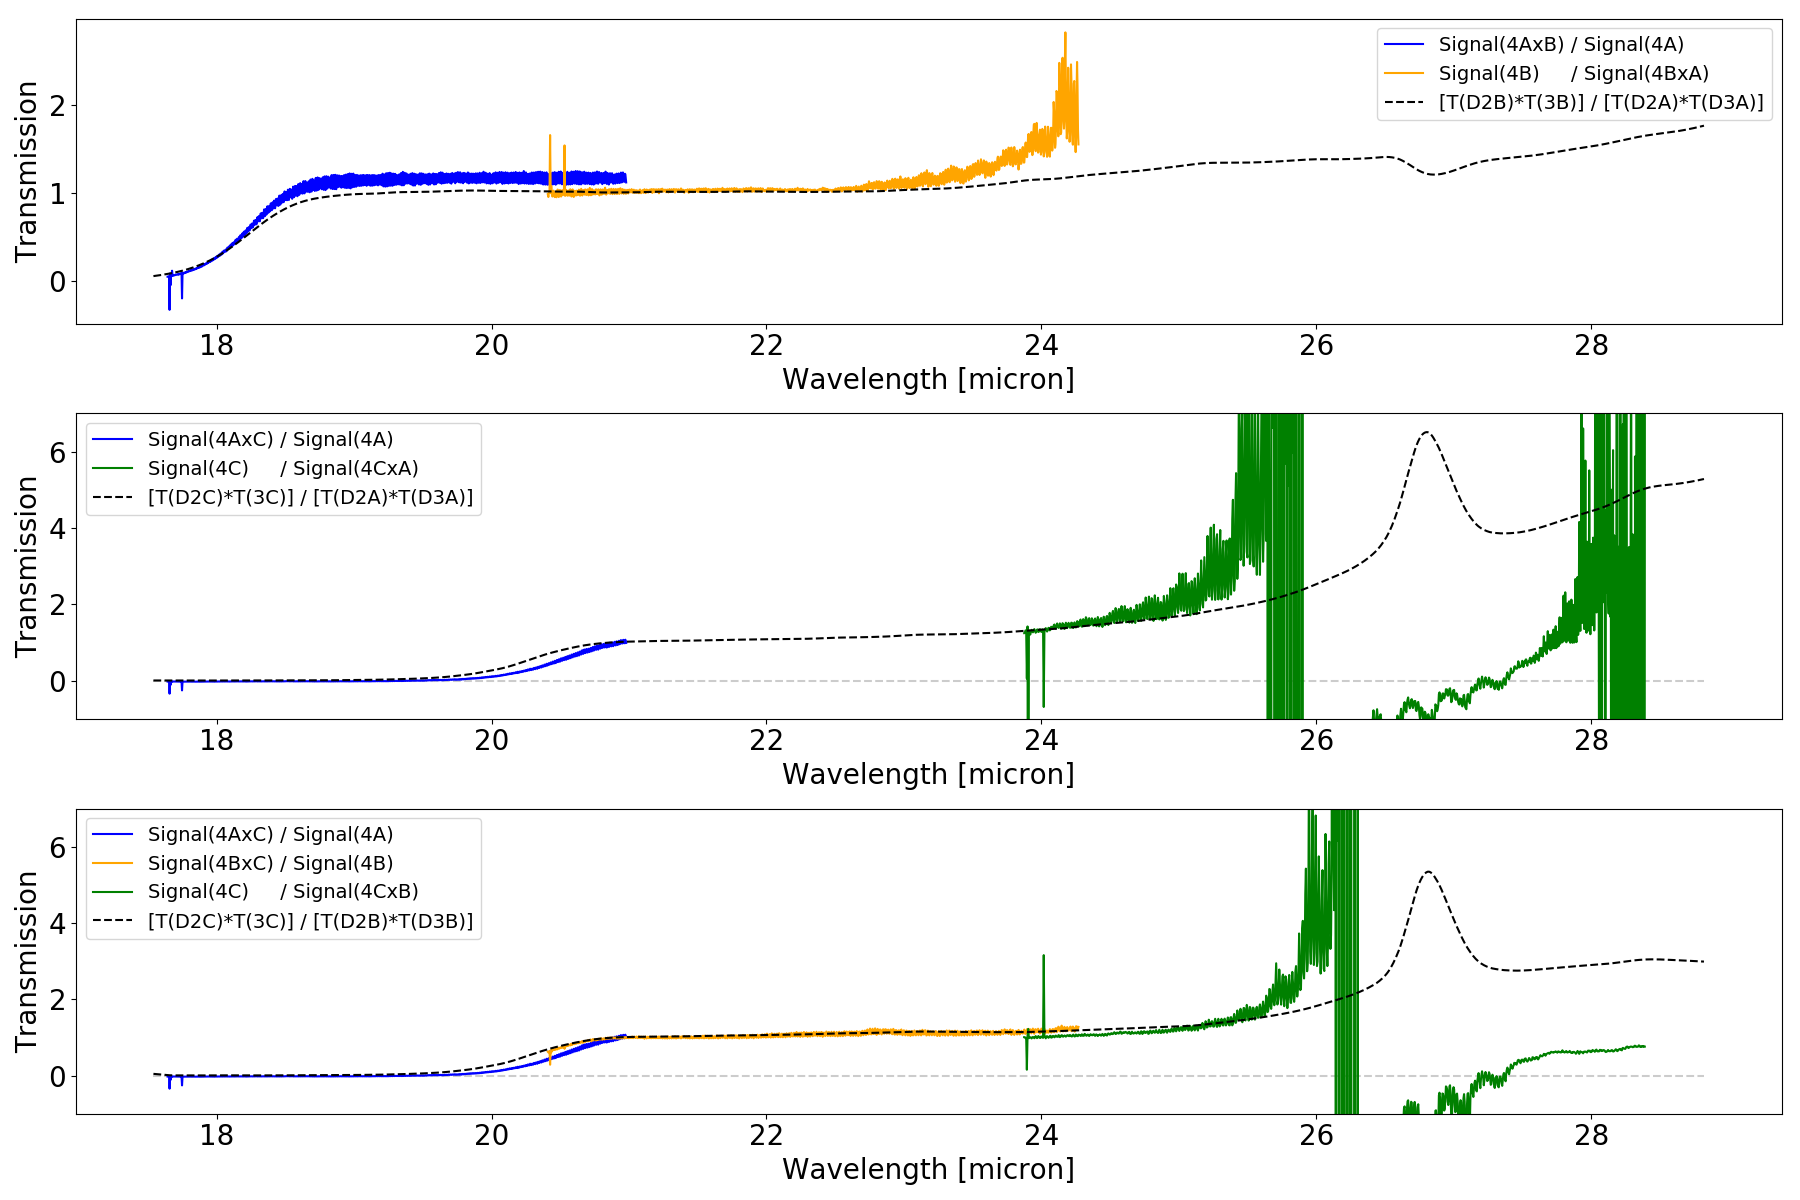

In [9]:
# channel 4
sel = (filterWave>=maux.MRS_bands['4A'][0]) & (filterWave<=maux.MRS_bands['4C'][1])
fig,axs = plt.subplots(3,1,figsize=(18,12))
axs[0].plot(lambdaMap['4A'][:,47],(S_pixMap["4AxB"]/S_pixMap["4A"])[:,47],'b',label='Signal(4AxB) / Signal(4A)')
axs[0].plot(lambdaMap['4B'][:,47],(S_pixMap["4B"]/S_pixMap["4BxA"])[:,47],'orange',label='Signal(4B)     / Signal(4BxA)')
axs[0].plot(filterWave[sel],((D2B*D3B)/(D2A*D3A) )[sel],'k',linestyle='dashed',label='[T(D2B)*T(3B)] / [T(D2A)*T(D3A)]')

axs[1].plot(lambdaMap['4A'][:,47],(S_pixMap["4AxC"]/S_pixMap["4A"])[:,47],'b',label='Signal(4AxC) / Signal(4A)')
axs[1].plot(lambdaMap['4C'][:,47],(S_pixMap["4C"]/S_pixMap["4CxA"])[:,47],'g',label='Signal(4C)     / Signal(4CxA)')
axs[1].plot(filterWave[sel],((D2C*D3C)/(D2A*D3A) )[sel],'k',linestyle='dashed',label='[T(D2C)*T(3C)] / [T(D2A)*T(D3A)]')
axs[1].set_ylim(-1,7)
axs[1].hlines(0,maux.MRS_bands['4A'][0],maux.MRS_bands['4C'][1],'gray',alpha=0.4,linestyle='dashed')

axs[2].plot(lambdaMap['4A'][:,47],(S_pixMap["4AxC"]/S_pixMap["4A"])[:,47],'b',label='Signal(4AxC) / Signal(4A)')
axs[2].plot(lambdaMap['4B'][:,47],(S_pixMap["4BxC"]/S_pixMap["4B"])[:,47],'orange',label='Signal(4BxC) / Signal(4B)')
axs[2].plot(lambdaMap['4C'][:,47],(S_pixMap["4C"]/S_pixMap["4CxB"])[:,47],'g',label='Signal(4C)     / Signal(4CxB)')
axs[2].plot(filterWave[sel],((D2C*D3C)/(D2B*D3B) )[sel],'k',linestyle='dashed',label='[T(D2C)*T(3C)] / [T(D2B)*T(D3B)]')
axs[2].set_ylim(-1,7)
axs[2].hlines(0,maux.MRS_bands['4A'][0],maux.MRS_bands['4C'][1],'gray',alpha=0.4,linestyle='dashed')

for plot in range(3):
    axs[plot].legend()
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Transmission')
plt.tight_layout()

### Remarks:
* $T(D1C)/T(D1B)$ = $T(D1C)/T(D1A)$ between 7um and 8.7um.
* $[T(D2C)*T(3C)] / [T(D2A)*T(D3A)]$ = $[T(D2C)*T(3C)] / [T(D2B)*T(D3B)]$ between 17.6um and 21um.
* The MRS signal ratios follow (within some margin) the ratio of dichroic transmissions.
* Errors in the MRS wavelength calibration emerge as clear offsets between the ratio of the responses and the dichroic transmission ratios.
* The observed signal in band 4C (in DN/sec) is sometimes negative and sometimes zero. This results in an erratic signal ratio profile.